In [1]:
# -*- coding: utf-8 -*-
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ht
import CoolProp as cp
import fluids
from prop_fluidos_intercambiadores import fluido_intercambiador

HIPOTESIS DE CALCULO:

1. Intercambiador de calor tubular de tubos lisos (sin aletas)
2. Flujo de gases de combustión de biomasa dentro de tubos
3. Flujo cruzado de aire externo a tubos
4. Distribución de tubos alineados


In [2]:
data_excel = pd.read_excel('/home/juan/Documents/Proyectos/2021_PDE/intercambiador/Calculo calentador aire mandioca Rev1.xls',sheet_name=1)
#data_excel = pd.read_excel('movies.xls')
data = data_excel.to_numpy()

In [17]:
#constantes de calculo
g = 9.8; cal2joule = 4.184
###########################################################
#           DATOS  del Intercambiador  
#
###########################################################
Gases = fluido_intercambiador('Gases combustion')
Aire = fluido_intercambiador('Aire')

Gases.temp_entrada = data[20,4]
Gases.temp_salida = data[21,4]
Aire.temp_entrada = data[22,4]
Aire.temp_salida = data[12,5]
Calor_ingreso = data[17,4]*cal2joule*1e3/3600
Calor_intercambiado = data[18,4]*cal2joule*1e3/3600
Q = Calor_intercambiado
Gases.calor_intercambiado, Aire.calor_intercambiado = [Q,Q]

Tubo_dext = data[13,4]
Tubo_esp = data[13,6]*1e-3
Tubo_dint = Tubo_dext-Tubo_esp*2
Tubo_long = 2.68
paso_tubos = data[47,4]
#paso_tubos = Tubo_dext*4/3
#paso_tubos_transversal
#paso_tubos_longitudinal
Rf = data[58,4]  #factor de ensuciamiento

Cmin = np.min((Aire.cp*Aire.caudal,Gases.cp*Gases.caudal))
DeltaT_max = Gases.temp_entrada-Aire.temp_entrada
Qmax = Cmin*DeltaT_max
rendimiento = Q/Qmax
print('Rendimiento del equipo = %.2f'%rendimiento)

Rendimiento del equipo = 0.32


In [18]:
LMTD = ht.LMTD(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada, Tho=Gases.temp_salida)
Ft = ht.F_LMTD_Fakheri(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada, Tho=Gases.temp_salida, 
                       shells=2)
UA = Q/(LMTD*Ft)
Upropuesto = 15
Apropuesta = UA/Upropuesto
Ntubos_0  = np.int(Apropuesta / (np.pi*Tubo_dext*Tubo_long))
Ntubos_0 = np.int(Ntubos_0/4)*4
print('Temperatura logaritmica media %.1f C'%LMTD)
print('G_Gases =%.1f m3/h'%Gases.caudal)
print('G_Aire =%.1f m3/h '%Aire.caudal)
print('Area propuesta =%.1f'%Apropuesta)
print('Numero de tubos %0d'%Ntubos_0)

Npasostubos = 1
Gases.area =  Tubo_dint**2/4*np.pi*Ntubos_0 #* Npasostubos
Gases.long = Tubo_dint
Gases.veloc = Gases.caudal / Gases.area

Gases.Reynolds()
#Npasotubos =  Re_design*(np.pi*Tubo_dext-Tubo_esp*2*Ntubos_0*m ) / (4*m_t)

Temperatura logaritmica media 247.5 C
G_Gases =0.5 m3/h
G_Aire =1.1 m3/h 
Area propuesta =16.6
Numero de tubos 32


In [16]:
Tubo_esp

0.002

Se propone un paso de tubos p = 1.5 D. En intercambiadores casco y tubo, lo usual es encontrar pasos p= D o p = 1.3D. Ver pej 
- Shah, R. K., & Sekulic, D. P. (2003). Fundamentals of heat exchanger design. John Wiley & Sons. 
- Cao, E. (2010). Heat transfer in process engineering. McGraw-Hill Education. (pags 509-522)

In [157]:
###########################################################
# Determinacion de Area de pasaje del aire por la carcasa
# alrededor del paquete de tubos
###########################################################
Tubo_area_ext = Tubo_dext**2/4*np.pi
carcasa_huelgo = 20e-3
nfilas = 4
ncolumnas = Ntubos_0/nfilas

carcasa_xmax,carcasa_ymax = [paso_tubos*(ncolumnas-1)+carcasa_huelgo*2+Tubo_dext,
                                                       paso_tubos*(nfilas-1)+carcasa_huelgo*2+Tubo_dext]
carcasa_area = carcasa_xmax*carcasa_ymax
Aire.area = (carcasa_ymax-Tubo_dext*nfilas)*Tubo_long
Aire.long = Tubo_dext
Aire.veloc = Aire.caudal  / Aire.area
print('Area de pasaje del Aire %.3f m2'%Aire.area)
print('Velocidad del Aire %.3f m/s'%Aire.veloc)

Area de pasaje del Aire 0.346 m2
Velocidad del Aire 3.154 m/s


In [158]:
Aire.Reynolds() 
Re = Aire.Re
pitch_parallel,pitch_normal = [paso_tubos,paso_tubos]
Pr = Aire.Pr
tube_rows = ncolumnas
Aire.Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows, pitch_parallel, pitch_normal, Pr_wall=None)
Aire.hc = Aire.Nu*Aire.long / Aire.k

ŽUKAUSKAS, A. Heat transfer from tubes in crossflow. En Advances in heat transfer. Elsevier, 1972. p. 93-160.

In [159]:
Gases.Nu = ht.conv_internal.turbulent_Colburn(Gases.Re,Gases.Pr)
Gases.hc = Gases.Nu*Gases.k/Gases.long
print('Reynolds gases = %.d'%Gases.Re)
print('Coeficiente conveccion gases = %.1f'%Gases.hc)

Reynolds gases = 6921
Coeficiente conveccion gases = 19.0


COLBURN, Allan P. A method of correlating forced convection heat-transfer data and a comparison with fluid friction. International Journal of Heat and Mass Transfer, 1964, vol. 7, no 12, p. 1359-1384.

In [160]:
Twall = (Aire.hc*Aire.temp_media+Gases.hc*Gases.temp_media) / (Aire.hc+Gases.hc)
Pr_w = cp.CoolProp.PropsSI('Prandtl','T',273+Twall,'P',101.325e3,'Air')
Aire.Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows, pitch_parallel, pitch_normal, Pr_wall=Pr_w)
Aire.hc = Aire.Nu*Aire.long / Aire.k

<IPython.core.display.Javascript object>


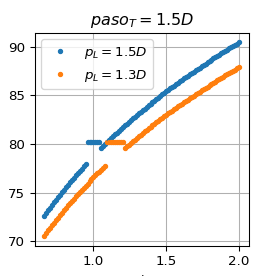

In [162]:
fig0,ax0 = plt.subplots(figsize=(3,3))
paso_longitudinal = Tubo_dext*1.5
paso_transversal = np.linspace(Tubo_dext,Tubo_dext*3,100)
paso_longitudinal2 = Tubo_dext*1.3
for i,paso_ti in enumerate(paso_transversal):
    Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows,paso_longitudinal,paso_ti, Pr_wall=None)
    Nu2 = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows,paso_longitudinal,paso_ti*1.3/1.5, Pr_wall=None)
    if i==0:
        lin1, = ax0.plot(paso_ti/paso_longitudinal,Nu,'.',label = '$p_L=1.5D$')
        lin2, = ax0.plot(paso_ti/paso_longitudinal,Nu2,'.',label = '$p_L=1.3D$')
    else:
        ax0.plot(paso_ti/paso_longitudinal,Nu,'.',color=lin1.get_color())
        ax0.plot(paso_ti/paso_longitudinal,Nu2,'.',color=lin2.get_color())

ax0.set_title('$paso_T = 1.5D$')
ax0.set_xlabel('$paso_T/paso_L$')
ax0.set_ylabel('Nu')
ax0.grid()
ax0.legend()

In [165]:
Ulimpio = 1 / (Tubo_dext/Tubo_dint/Gases.hc+1/Aire.hc )
Rf = 0.002
U = 1 / (1/Ulimpio + Rf *(1+Tubo_dext/Tubo_dint))

A_calculo = Q / (U*LMTD*Ft)

print('U=%.2f   Acalculo = %.2f'%(U,A_calculo))
print('A real inicial %.2f'%Apropuesta)

U=15.12   Acalculo = 16.42
A real inicial 16.55


In [309]:
# Caida de presion

# Calculo para flujo en tubos
roughness = fluids.roughness_Farshad('Carbon steel, bare', D=D)

f_c = fluids.friction.friction_factor(Re=Gases.Re, eD=roughness/Di)

f_c2 = 1.2*(0.0014+0.125/Gases.Re**.32)

Gtubos = m_c*Npasotubos*4 / (Ntubos*np.pi*Di**2)


Delta_p_friccion = 4*f_c*Npasotubos*L_tubos*Gtubos**2/(2*Di*rho_c)*(mu_c/mu_w)**-0.14

Delta_p_cabezales = 4*Npasotubos*Gtubos**2/rho_c/2

Delta_p_tubos = Delta_p_cabezales+Delta_p_friccion

print('factor friccion tubos = %4f '%f_c)
print('Gtubos = %.1f'%Gtubos)
print('Delta p friccion = %.2f'%Delta_p_friccion)
print('Delta p cabezales = %.2f'%Delta_p_cabezales)
print('Delta p tubos = %.2f'%Delta_p_tubos)

factor friccion tubos = 0.030748 
Gtubos = 350.1
Delta p friccion = 2971.88
Delta p cabezales = 1489.85
Delta p tubos = 4461.73


In [327]:
#calculo para flujo en carcasa


LSpacing = Dcarcasa*0.25
NBaffles = np.floor(L_tubos / LSpacing)

Delta_p_carcasa = ht.conv_tube_bank.dP_Kern(m_f, rho_f, mu_f, Dcarcasa, LSpacing, pitch, D, NBaffles, mu_w=mu_w)
print('Delta p carcasa = %.1f'%Delta_p_carcasa)


Delta p carcasa = 6280.5
